## Tensor factorization

#### Goal: Decompose matrix (E) [M X N X T] into  H [M X h], A [h X N X t], T [t X T]

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
M, N, T = 4, 3, 6
E_np = np.random.randn(M, N, T)

In [3]:
E_np = np.abs(E_np)

In [4]:
E_np = np.divide(E_np, E_np.max())

In [5]:
E_np

array([[[ 0.87040848,  0.53706423,  0.26908776,  0.17061392,  0.01757035,
          0.16487224],
        [ 0.13057979,  0.03030039,  0.76963236,  0.49340988,  0.52477403,
          0.40701924],
        [ 0.2971993 ,  0.91078131,  0.46281024,  0.47778498,  0.84820028,
          0.16711341]],

       [[ 0.38515828,  0.16408813,  0.03671247,  0.64823068,  0.32059691,
          0.4002224 ],
        [ 0.31763234,  0.41064071,  0.2038274 ,  0.09008193,  0.16361373,
          0.55699168],
        [ 0.66306793,  0.3419301 ,  0.32785813,  0.31837216,  0.27082809,
          0.39007442]],

       [[ 0.276159  ,  0.18561849,  0.3981551 ,  0.02587821,  0.48943101,
          0.64019114],
        [ 0.13154903,  0.20887952,  0.04947734,  0.14516244,  0.43151843,
          0.52246837],
        [ 0.48529395,  0.49423497,  0.2019355 ,  0.76495262,  0.22156937,
          0.14011292]],

       [[ 0.4544879 ,  0.00442043,  0.23140011,  0.14417104,  1.        ,
          0.45964817],
        [ 0.35538703,  0

In [6]:
(pd.Series([np.random.random() for x in range(1000)])>0.8).sum()

203

### Masking appx. 20% of entries

In [8]:
E_np_masked = E_np.copy()
for i in range(M):
    for j in range(N):
        for k in range(T):
            if np.random.random()>0.8:
                E_np_masked[i, j, k] = np.NAN

In [9]:
h = 2
t = 3

In [10]:
E = tf.constant(E_np_masked, dtype='float32')

initializer = tf.random_uniform_initializer(minval=0.2, maxval=1)

H =  tf.get_variable("H", [M, h], initializer=initializer)
A =  tf.get_variable(name="A", shape=[h, N, t], initializer=initializer)
T =  tf.get_variable(name="T", shape=[t, T], initializer=initializer)

In [11]:
H.get_shape(), A.get_shape(), T.get_shape()

(TensorShape([Dimension(4), Dimension(2)]),
 TensorShape([Dimension(2), Dimension(3), Dimension(3)]),
 TensorShape([Dimension(3), Dimension(6)]))

In [12]:
HA = tf.tensordot(H, A,axes = [[1], [0]])
HAT = tf.tensordot(HA, T, axes=[[2], [0]])
HAT.get_shape()

TensorShape([Dimension(4), Dimension(3), Dimension(6)])

In [13]:
E.get_shape()

TensorShape([Dimension(4), Dimension(3), Dimension(6)])

#### Boolean mask 

In [14]:
mask = pd.Panel(E_np_masked).notnull().values

In [15]:
#cost of Frobenius norm
f_norm = tf.reduce_sum(tf.pow(tf.boolean_mask(E, mask) - tf.boolean_mask(HAT, mask), 2))

In [16]:
f_norm

<tf.Tensor 'Sum:0' shape=() dtype=float32>

In [17]:
lr = 0.01
optimize = tf.train.AdagradOptimizer(lr).minimize(f_norm)

In [18]:
max_iter=10000
display_step = int(max_iter/10)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print "cost, #iterations"
    pre_loss = 10e12
    for i in xrange(max_iter):
       
        loss, _ = sess.run([f_norm, optimize])
        if i%display_step==0:
            print loss, ",", i
    A_out = sess.run(A)
    H_out = sess.run(H)
    T_out = sess.run(T)
    HAT_out = sess.run(HAT)
    

cost, #iterations
40.4676 , 0
2.81335 , 1000
2.29145 , 2000
2.05039 , 3000
1.89775 , 4000
1.79153 , 5000
1.70362 , 6000
1.61857 , 7000
1.53006 , 8000
1.4365 , 9000


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

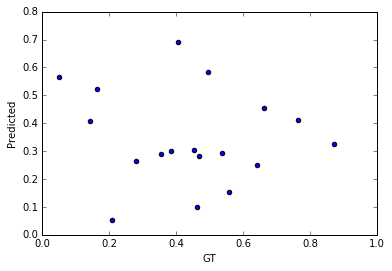

In [31]:
plt.scatter(E_np[~mask], HAT_out[~mask])
plt.xlabel("GT")
plt.ylabel("Predicted")

In [32]:
from sklearn.metrics import mean_squared_error

In [34]:
rmse_error = np.mean(mean_squared_error(E_np[~mask], HAT_out[~mask] ))
rmse_error

0.089942666769340623